# Extracting LBP features - Notebook 4

- Extracts features from all data sets
- Saves features to be used during training and evaluating



In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
from tqdm import tqdm
import joblib
from skimage.feature import local_binary_pattern
plt.style.use('ggplot')

#set up paths
projectRoot = Path().resolve().parent
datasetPath = projectRoot / "CV2024_CW_Dataset"
outputRoot = projectRoot / "ModifiedDataset"

#ddefine dataset paths
trainOutputPath = outputRoot / "train" / "images"
trainOutputLabelPath = outputRoot / "train" / "labels"
testOutputPath = outputRoot / "test" / "images"
testOutputLabelPath = outputRoot / "test" / "labels"
valOutputPath = outputRoot / "validation" / "images"
valOutputLabelPath = outputRoot / "validation" / "labels"
augDataPath = outputRoot / "AugmentedData" / "images"
augLabelPath = outputRoot / "AugmentedData" / "labels"

#setup features directory
featuresDir = outputRoot / "features"
featuresDir.mkdir(parents=True, exist_ok=True)

# verify the paths
for path in [trainOutputPath, trainOutputLabelPath, testOutputPath, testOutputLabelPath, valOutputPath, valOutputLabelPath]:
    if not path.exists():
        print(f"Warning: Path {path} does not exist")

print("Paths set up successfully.")

Paths set up successfully.


## LBP Feature Extraction Function

In [4]:
def compute_lbp_features(image, radius=3, n_points=24, method='uniform'):
    ##computing lbp features for a img
    # make sure img is greyscale
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # compute LBP
    lbp = local_binary_pattern(image, n_points, radius, method)
    
    # calculate histogram of LBP
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    
    return hist

## Dataset Feature Extraction

In [5]:
def extract_dataset_features(image_paths, label_paths, lbp_params=None):
    # extract lbp features for all imgs in a dataset
    if lbp_params is None:
        lbp_params = {
            'radius': 3,
            'n_points': 24,
            'method': 'uniform'
        }
    
    features = []
    labels = []
    
    #extract features/labels
    for img_path, label_path in tqdm(zip(image_paths, label_paths), total=len(image_paths), desc="Extracting LBP features"):

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        with open(label_path, 'r') as f:
            label = int(f.read().strip())
        
        # extract LBP features
        lbp_features = compute_lbp_features(
            image,
            radius=lbp_params['radius'],
            n_points=lbp_params['n_points'],
            method=lbp_params['method']
        )
        
        features.append(lbp_features)
        labels.append(label)
    
    return np.array(features), np.array(labels)

## Prepare and Save Features

In [6]:
def prepare_dataset_features(dataset_path, output_path, dataset_type, lbp_params=None):
    # method prepares and saves lbp features for a dataset
    
    images_path = os.path.join(dataset_path, dataset_type, "images")
    labels_path = os.path.join(dataset_path, dataset_type, "labels")
    
    # get all img files
    image_files = sorted([f for f in os.listdir(images_path) if f.endswith('.jpeg')])
    
    #create full paths
    image_paths = [os.path.join(images_path, f) for f in image_files]
    label_paths = [os.path.join(labels_path, f.replace('.jpeg', '.txt')) for f in image_files]
    
    # extract features
    X, y = extract_dataset_features(image_paths, label_paths, lbp_params)
    
    # create output directory if it dosent already exist
    os.makedirs(output_path, exist_ok=True)
    
    # save features/labels
    joblib.dump((X, y), os.path.join(output_path, f"{dataset_type}_lbp_features.joblib"))
    
    print(f"Saved {dataset_type} LBP features with shape {X.shape}")
    return X, y

## Visualization Functions

In [7]:
def visualize_lbp_features(image_path, lbp_params=None):
    #visualize lbp featuress for an img
    if lbp_params is None:
        lbp_params = {
            'radius': 3,
            'n_points': 24,
            'method': 'uniform'
        }
    
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Compute LBP
    lbp_image = local_binary_pattern(
        image, 
        lbp_params['n_points'], 
        lbp_params['radius'], 
        lbp_params['method']
    )
    
    return image, lbp_image

def display_sample_lbp_features(image_paths, lbp_params=None, num_samples=3):
    ##display lbp features for sample imgs
    import random
    
    # selecting random samples
    if len(image_paths) > num_samples:
        sample_paths = random.sample(image_paths, num_samples)
    else:
        sample_paths = image_paths
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4 * num_samples))
    
    for i, img_path in enumerate(sample_paths):
        # get original img and LBP visualisation
        original, lbp_img = visualize_lbp_features(img_path, lbp_params)
        
        # display original img
        axes[i, 0].imshow(original, cmap='gray')
        axes[i, 0].set_title(f"Original Image")
        axes[i, 0].axis('off')
        
        # display LBP features
        axes[i, 1].imshow(lbp_img, cmap='jet')
        axes[i, 1].set_title(f"LBP Features")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

## Parameter Optimization Function

In [8]:
def optimize_lbp_parameters(sample_images, sample_labels, param_grid):
    ## find optimal LBP parameters using small subset of imgs
    from sklearn.model_selection import GridSearchCV
    from sklearn.svm import SVC
    
    # define the parameter grid
    radii = param_grid.get('radius', [3])
    n_points_list = param_grid.get('n_points', [24])
    methods = param_grid.get('method', ['uniform'])
    
    #store results
    results = []
    
    total_combinations = len(radii) * len(n_points_list) * len(methods)
    pbar = tqdm(total=total_combinations, desc="Optimizing LBP parameters")
    
    for radius in radii:
        for n_points in n_points_list:
            for method in methods:
                lbp_params = {
                    'radius': radius,
                    'n_points': n_points,
                    'method': method
                }
                
                # extract features for samples
                sample_features = []
                for img_path in sample_images:
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    features = compute_lbp_features(img, **lbp_params)
                    sample_features.append(features)
                
                # train a simple SVM
                svm = SVC(kernel='linear')
                svm.fit(sample_features, sample_labels)
                score = svm.score(sample_features, sample_labels)
                
                # store results
                results.append({
                    'params': lbp_params,
                    'score': score,
                    'feature_dim': len(sample_features[0])
                })
                
                pbar.update(1)
    
    pbar.close()
    
    # find best parameters
    results.sort(key=lambda x: x['score'], reverse=True)
    best_params = results[0]['params']
    
    print(f"Best LBP parameters: {best_params} with score {results[0]['score']:.4f}")
    print(f"Feature dimension: {results[0]['feature_dim']}")
    
    return best_params

## Extract Features from All Datasets

In [9]:
# set LBP parameters
lbp_params = {
    'radius': 3,        
    'n_points': 24, 
    'method': 'uniform'  
}

print("Extracting LBP features from datasets...")

# training set
X_train, y_train = prepare_dataset_features(
    str(outputRoot),
    str(features_dir),
    "train",
    lbp_params=lbp_params
)

# validation set
X_val, y_val = prepare_dataset_features(
    str(outputRoot),
    str(features_dir),
    "validation",
    lbp_params=lbp_params
)

# test set
X_test, y_test = prepare_dataset_features(
    str(outputRoot),
    str(features_dir),
    "test",
    lbp_params=lbp_params
)

# augmented data set
if augDataPath.exists() and augLabelPath.exists():
    X_aug, y_aug = prepare_dataset_features(
        str(outputRoot),
        str(features_dir),
        "AugmentedData",
        lbp_params=lbp_params
    )
    print(f"Augmented features shape: {X_aug.shape}")
else:
    print("Augmented dataset not found, skipping feature extraction.")

print("LBP feature extraction complete!")
print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Test features shape: {X_test.shape}")

Extracting LBP features from datasets...


 ... (more hidden) ...


Saved train LBP features with shape (1916, 26)


 ... (more hidden) ...


Saved validation LBP features with shape (478, 26)


 ... (more hidden) ...


Saved test LBP features with shape (458, 26)


 ... (more hidden) ...

Saved AugmentedData LBP features with shape (1169, 26)
Augmented features shape: (1169, 26)
LBP feature extraction complete!
Training features shape: (1916, 26)
Validation features shape: (478, 26)
Test features shape: (458, 26)


## Visualize Feature Examples

Displaying LBP features for sample images...


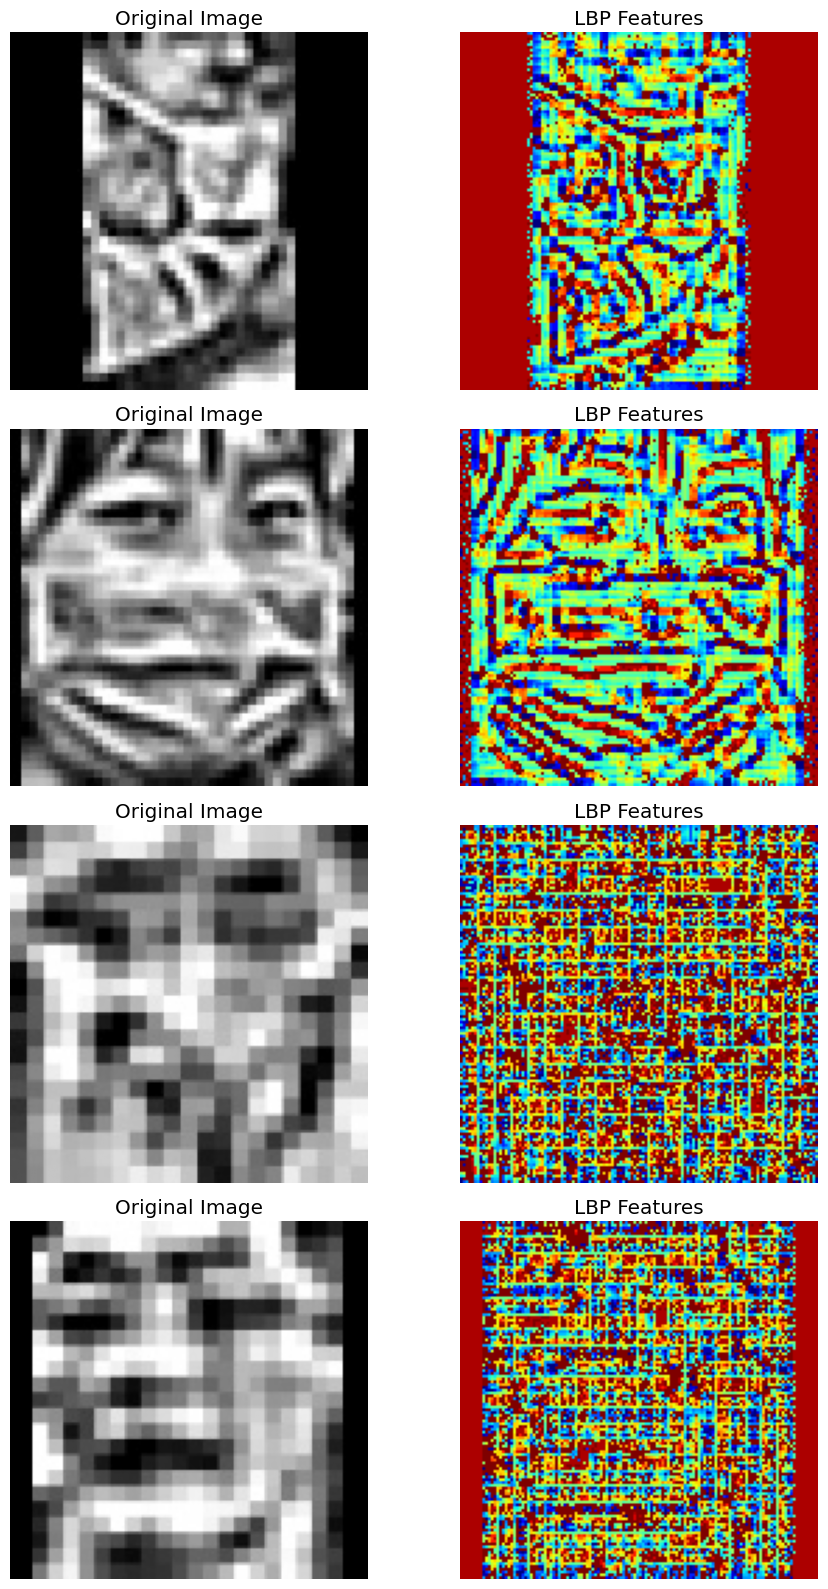

In [10]:
# ddisplay LBP features for sample imgs
print("Displaying LBP features for sample images...")

# Path to training images
train_image_dir = str(trainOutputPath)
train_image_files = sorted([f for f in os.listdir(train_image_dir) if f.endswith('.jpeg')])
train_image_paths = [os.path.join(train_image_dir, f) for f in train_image_files]

# Show sample images with LBP features
display_sample_lbp_features(train_image_paths, lbp_params, num_samples=4)

## Compare Features Across Classes


Displaying LBP features by class...


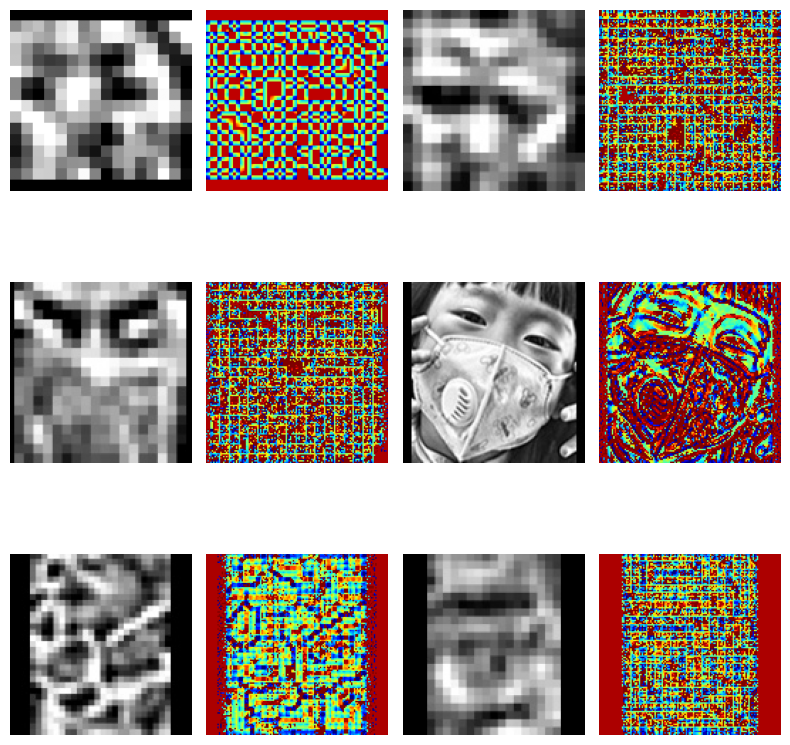

In [13]:
def display_class_lbp_features(image_dir, label_dir, lbp_params=None, samples_per_class=2):
    import random
    # group images by class
    class_images = {0: [], 1: [], 2: []}
    
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpeg')]
    for img_file in image_files:
        label_file = img_file.replace('.jpeg', '.txt')
        with open(os.path.join(label_dir, label_file), 'r') as f:
            label = int(f.read().strip())
        class_images[label].append(os.path.join(image_dir, img_file))
    
    fig, axes = plt.subplots(len(class_images), samples_per_class*2, 
                            figsize=(samples_per_class*4, len(class_images)*3))
    
    class_names = {0: "No Mask", 1: "Mask", 2: "Improper Mask"}
    
    # display samples from each class
    for class_idx, (label, images) in enumerate(class_images.items()):
        if len(images) < samples_per_class:
            sample_paths = images
        else:
            sample_paths = random.sample(images, samples_per_class)
        
        for sample_idx, img_path in enumerate(sample_paths):
            original, lbp_img = visualize_lbp_features(img_path, lbp_params)
            
            # display original
            axes[class_idx, sample_idx*2].imshow(original, cmap='gray')
            if sample_idx == 0:
                axes[class_idx, sample_idx*2].set_ylabel(class_names[label])
            axes[class_idx, sample_idx*2].axis('off')
            
            # Display LBP
            axes[class_idx, sample_idx*2+1].imshow(lbp_img, cmap='jet')
            axes[class_idx, sample_idx*2+1].axis('off')
    
    plt.tight_layout()
    plt.show()

print("\nDisplaying LBP features by class...")
display_class_lbp_features(str(trainOutputPath), str(trainOutputLabelPath), 
                         lbp_params=lbp_params, samples_per_class=2)